In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
figsize = (10,10)

In [3]:
#Corta una imagen en dos
ori=cv2.imread("original.jpg")
[x,y,a]=ori.shape
left=ori[:,:int(y/2)+300,:]
right=ori[:,int(y/2):,:]
cv2.imwrite('left.jpg',left)
cv2.imwrite('right.jpg',right)

True

In [4]:
rgb_l = cv2.cvtColor(cv2.imread("left.jpg"),cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l,cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("right.jpg"),cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r,cv2.COLOR_RGB2GRAY)

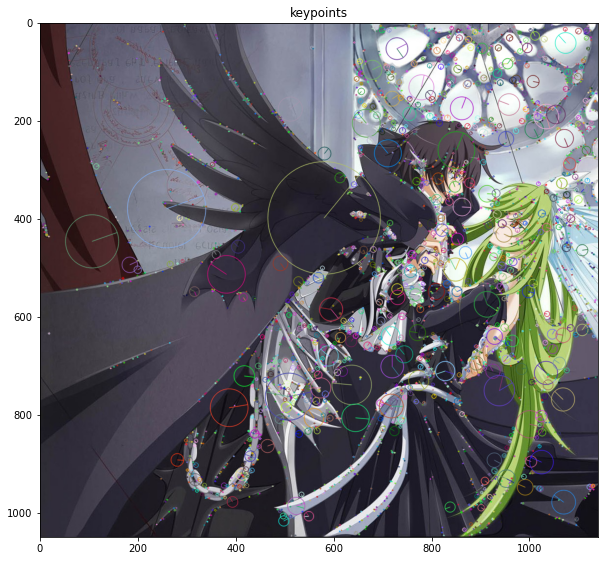

In [5]:
# use orb if sift is not installed
try:
    feature_extractor = cv2.xfeatures2d.SIFT_create()
except:
    feature_extractor = cv2.ORB()
 

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l,None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r,None)

test=cv2.drawKeypoints(rgb_l,kp_l,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()

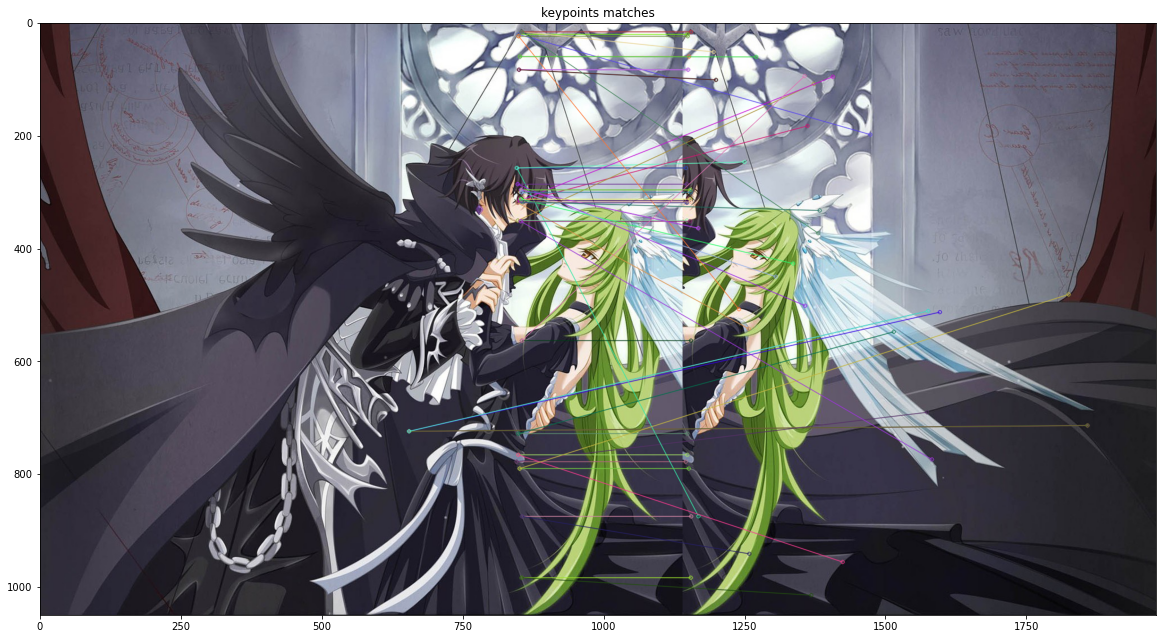

In [6]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l,desc_r, k=2)

# Apply ratio test
good_match = []
for m in matches:
    if m[0].distance/m[1].distance < 0.5:
        good_match.append(m)
good_match_arr = np.asarray(good_match)

# show only 30 matches
im_matches = cv2.drawMatchesKnn(rgb_l,kp_l,rgb_r,kp_r,good_match[0:30],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()

In [7]:
good_kp_l = np.array([ kp_l[m.queryIdx].pt for m in good_match_arr[:,0] ]).reshape(-1,1,2)
good_kp_r = np.array([ kp_r[m.trainIdx].pt for m in good_match_arr[:,0] ]).reshape(-1,1,2)
H, masked = cv2.findHomography(good_kp_r, good_kp_l, cv2.RANSAC, 5.0)

print(H)

[[ 9.99992396e-01  1.51453813e-06  8.39999691e+02]
 [-6.48556281e-06  9.99996572e-01  9.31798702e-04]
 [-5.55140694e-09 -1.36986767e-09  1.00000000e+00]]


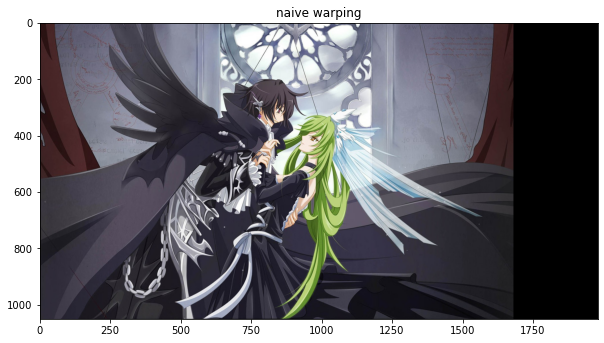

In [8]:
rgb_r_warped = cv2.warpPerspective(rgb_r,H,(rgb_l.shape[1] + rgb_r.shape[1], rgb_l.shape[0]))
rgb_r_warped[0:rgb_l.shape[0], 0:rgb_l.shape[1]] = rgb_l

plt.figure(figsize=figsize)
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()

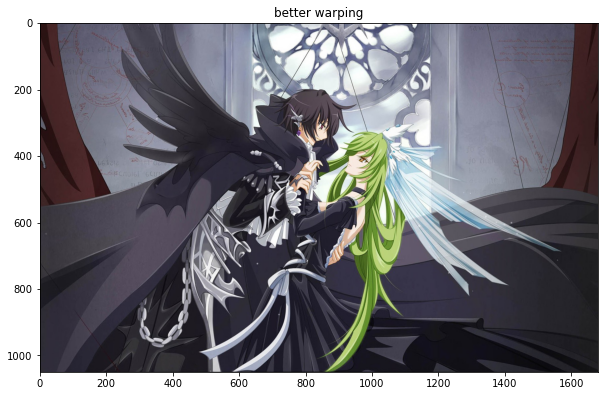

In [9]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H
    from: https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
    '''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht@H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

result = warpTwoImages(rgb_l, rgb_r, H)

plt.figure(figsize=figsize)
plt.imshow(result)
plt.title("better warping")
plt.show()